In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev, get_ds_in_pressure_range
from isca_tools.thesis.lapse_integral import fitting_2_layer, integral_lapse_dlnp_hydrostatic, get_temp_const_lapse, \
    get_temp_mod_parcel_lapse, get_temp_2_layer_approx, fitting_2_layer_xr
import isca_tools.thesis.lapse_integral_simple as lapse_integral2
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory_numerical, get_temp_adiabat_surf, get_temp_adiabat
from isca_tools.thesis.profile_fitting import get_mse_env, get_lnb_lev_ind, get_mse_prof_rms
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes
from isca_tools.papers.byrne_2021 import get_quant_ind

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
# Info for loading in data
exp_dir = {'aquaplanet': 'tau_sweep/aquaplanet/depth=1/',
           'land': 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'}
kappa_names = ['k=1_2m', 'k=1_5_2m']
kappa_names = ['k=1_2m']
kappa_names = ['k=3']
n_kappa = len(kappa_names)

region = 'tropics'
hemisphere = 'north'
season = 'summer'
lat_min = 0
lat_max = 20

if hemisphere == 'north':
    lat_min = np.abs(lat_min)
    lat_max = np.abs(lat_max)
else:
    lat_min = -np.abs(lat_max)
    lat_max = -np.abs(lat_min)

season_months = {'summer': {'tropics': {'north': [5, 6, 7, 8, 9, 10],
                                        'south': [11, 12, 1, 2, 3, 4]},
                            'not_tropics': {'north': [6, 7, 8],
                                            'south': [12, 1, 2]}},
                 'winter': {}}
for key in ['tropics', 'not_tropics']:
    season_months['winter'][key] = {'north': season_months['summer'][key]['south'],
                                    'south': season_months['summer'][key]['north']}

# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'cape',
            'ps', 'convflag', 'klzbs', 'cin']  # only keep variables required to compute relative humidity and MSE
use_time_start = 360 * 2

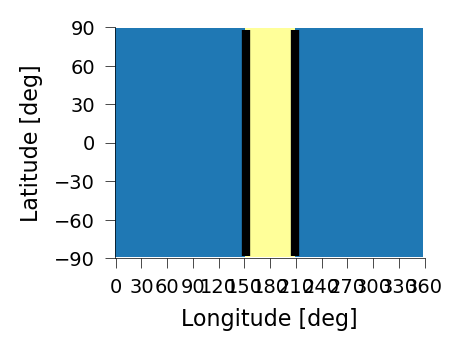

In [4]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir['land'],
                              kappa_names[0].replace('_2m', ''), 'land.nc')

fig, ax = plt.subplots(1, 1)
fig_resize(fig, 2)
isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]  # get the longitude coordinates of land

### Convert ds to CESM like data
Below I convert the variable names in the dataset into those expected from CESM.

In [5]:
ds = {key: [] for key in exp_dir}
albedo = {key: [] for key in exp_dir}
tau_sw = {key: [] for key in exp_dir}
tau_lw = {key: [] for key in exp_dir}
with tqdm(total=n_kappa * 2, position=0, leave=True) as pbar:
    for key in exp_dir:
        for j in range(n_kappa):
            ds_use = isca_tools.load_dataset(exp_dir[key] + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[
                var_keep]
            ds_use['sphum'] = ds_use.sphum.isel(pfull=-1)  # only keep surface SPHUM

            ds_use = ds_use.sel(lat=slice(lat_min, lat_max))
            # Only keep land longitudes - for aquaplanet, does not matter which we keep
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

            # Only load in months of interest for season and hemisphere
            ds_use = isca_tools.utils.annual_time_slice(ds_use, season_months[season][region][hemisphere])
            # Stack longitude and time into new sample dimension to match CESM
            # ds_use = ds_use.stack(sample=("lon", "time"), create_index=False).chunk(dict(sample=-1))
            ds[key] += [ds_use.load()]

        namelist = isca_tools.load_namelist(exp_dir[key] + kappa_names[j])  # Need this for albedo_value
        albedo[key] += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw[key] += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw[key] += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        ds[key] = xr.concat(ds[key], dim=xr.DataArray(tau_lw[key], dims="tau_lw",
                                                      name='tau_lw'))

# Concatenate ds along surf dimension
ds = xr.concat([ds[key] for key in ds],
               dim=xr.DataArray([key for key in ds], dims="surf", name='surf'))

# Rename variables to match CESM
ds = ds.rename({'temp': 'T', 'sphum': 'QREFHT',
                'height': 'Z3', 'cape': 'CAPE', 'ps': 'PS',
                'pfull': 'lev'})

# sigma_half reflects ds_us.pfull (starts with 0 - space, ends with 1 - surface)
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
# hybm are sigma full levels
hybm = np.convolve(sigma_levels_half, np.ones(2) / 2,
                   'valid')  # sigma levels corresponding to pressure levels
ds['hybm'] = ds.lev * 0 + hybm  # convert to xarray

# choose lowest model level as REFHT
ds['TREFHT'] = ds.T.isel(lev=-1)
ds['ZREFHT'] = ds.Z3.isel(lev=-1)
ds['PREFHT'] = ds.PS * ds.hybm.isel(lev=-1)

  0%|          | 0/2 [00:00<?, ?it/s]

### Compute variables for lapse fitting
Below, I compute the LCL and FT variables required to do the vertical temperature profile fitting.

In [6]:
def get_P(ds):
    return ds.PS * ds.hybm


ds['mse_REFHT'] = moist_static_energy(ds.TREFHT, ds.QREFHT, ds.ZREFHT)
ds['p_lcl'], ds['T_lcl_parcel'] = lcl_metpy(ds.TREFHT, ds.QREFHT, ds.PREFHT)
ds['T_lcl_env'] = get_var_at_plev(ds.T, get_P(ds), ds.p_lcl)
# ds['mse_env'] = get_mse_env(ds.T, ds.P, ds.Z3, ds.p_lcl, sphum_below_lcl=ds.QREFHT)

In [7]:
p_ft = 500 * 100
ds['T_ft_env'] = get_var_at_plev(ds.T, get_P(ds), p_ft)
ds['Z_ft_env'] = get_var_at_plev(ds.Z3, get_P(ds), p_ft)
ds['mse_ft_env_sat'] = moist_static_energy(ds.T_ft_env, sphum_sat(ds.T_ft_env, p_ft), ds.Z_ft_env)

## Analysis as function of temperature quantile, $x$
Next, for a range of `TREFHT` quantiles, I first get the `ds` conditioned on these temperatures.

Then I compute the parameters and error for the `const` and `mod_parcel` lapse rate profiles on these sample days.

In [8]:
def get_ds_quant_single_coord(ds, quant=90, range_below=0.5, range_above=0.5):
    quant_mask = get_quant_ind(ds.TREFHT.squeeze(), quant, range_below, range_above, av_dim=['lon', 'time'],
                               return_mask=True)
    ds_use = ds.where(quant_mask).stack(sample=("lon", "time"), create_index=False).chunk(dict(sample=-1))
    ds_use = ds_use.load()
    ds_use = ds_use.where(ds_use.TREFHT > 0, drop=True)
    return ds_use


def get_ds_quant(ds, quant=90, range_below=0.5, range_above=0.5, n_keep=None):
    quant_mask = get_quant_ind(ds.TREFHT, quant, range_below, range_above, av_dim=['lon', 'time'], return_mask=True)
    # n_keep is so can concat ds of different quantiles. A given quant range will give slightly different numbers of samples at each location.
    # Through providing n_keep, you can ensure the number is always the same.
    n_keep_max = int(quant_mask.sum(dim=['lon', 'time']).min())
    if n_keep is None:
        n_keep = n_keep_max
    if n_keep > n_keep_max:
        raise ValueError(f'n_keep={n_keep} > n_keep_max={n_keep_max}')
    ds_out = []
    for i in range(ds.tau_lw.size):
        ds_use_j = []
        for j in range(ds.surf.size):
            ds_use_k = []
            for k in range(ds.lat.size):
                ds_use_k.append(
                    get_ds_quant_single_coord(ds.isel(tau_lw=i, surf=j, lat=k, drop=True), quant, range_below,
                                              range_above).isel(sample=slice(0, n_keep)))
            ds_use_k = xr.concat(ds_use_k, dim=ds.lat)
            ds_use_j.append(ds_use_k)
        ds_use_j = xr.concat(ds_use_j, dim=ds.surf)
        ds_out.append(ds_use_j)
    ds_out = xr.concat(ds_out, dim=ds.tau_lw)
    return ds_out

In [9]:
quant_range = 0.02
n_sample = 3
quant_all = np.arange(1, 100, 7)
ds_quant = []
for i in tqdm(quant_all):
    ds_quant.append(get_ds_quant(ds, i, quant_range, quant_range, n_sample))
ds_quant = xr.concat(ds_quant, dim=xr.DataArray(quant_all, dims="quant", name='quant'))

  0%|          | 0/15 [00:00<?, ?it/s]

In [10]:
def get_lapse_fitting_info(ds, n_lcl_mod=7, p_lcl_log_max_shift=0.06):
    ds.attrs['p_lcl_log_mod'] = np.linspace(-p_lcl_log_max_shift, p_lcl_log_max_shift, n_lcl_mod)
    ind_phys_lcl = int(np.where(ds.p_lcl_log_mod == 0)[0][0])
    ds.attrs['n_lev_above_integral'] = 3
    var_names = ['lapse', 'integral', 'error']

    p_lcl_use = [(10 ** (np.log10(ds.p_lcl) + ds.p_lcl_log_mod[i])) for i in range(n_lcl_mod)]
    ds['p_lcl2'] = xr.concat(p_lcl_use, dim=xr.DataArray(ds.p_lcl_log_mod, name='lcl_mod', dims='lcl_mod'))
    ds['T_lcl_env2'] = get_var_at_plev(ds.T, get_P(ds), ds.p_lcl2)
    with tqdm(total=2, position=0, leave=True) as pbar:
        for key in ['const', 'mod_parcel']:
            var = fitting_2_layer_xr(ds.T, get_P(ds), ds.TREFHT, ds.PREFHT, ds.T_lcl_env2,
                                     ds.p_lcl2, ds.T_ft_env,
                                     p_ft, n_lev_above_upper2_integral=ds.n_lev_above_integral,
                                     method_layer2=key)
            # Must include fillna as inf to deal with all nan slice.
            ind_best = var[2].sum(dim='layer', skipna=False).fillna(np.inf).argmin(dim='lcl_mod')
            for k, key2 in enumerate(var_names):
                ds[f'{key}1_{key2}'] = var[k].isel(lcl_mod=ind_phys_lcl)
                ds[f'{key}2_{key2}'] = var[k].isel(lcl_mod=ind_best)
            ds[f'{key}2_p_lcl'] = ds['p_lcl2'].isel(lcl_mod=ind_best)
            ds[f'{key}2_T_lcl_env'] = ds['T_lcl_env2'].isel(lcl_mod=ind_best)
            pbar.update(1)
    return ds

In [11]:
def get_lapse_fitting_info2(ds, n_rh_mod=7, rh_max_shift=0.21, temp_surf_lcl_calc=300):
    ds.attrs['rh_mod'] = np.round(np.linspace(-rh_max_shift, rh_max_shift, n_rh_mod), 2)
    ind_phys_rh = int(np.where(ds.rh_mod == 0)[0][0])
    ds.attrs['n_lev_above_integral'] = 3
    ds.attrs['temp_surf_lcl_calc'] = temp_surf_lcl_calc
    var_names = ['lapse', 'integral', 'error']

    rh_use = [ds.rh_REFHT + ds.rh_mod[i] for i in range(n_rh_mod)]
    ds['rh_REFHT2'] = xr.concat(rh_use, dim=xr.DataArray(ds.rh_mod, name='rh_mod', dims='rh_mod'))
    ds['rh_REFHT2'] = ds['rh_REFHT2'].clip(0, 1)        # ensure valid rh range
    with tqdm(total=2, position=0, leave=True) as pbar:
        for key in ['const', 'mod_parcel']:
            var = lapse_integral2.fitting_2_layer_xr(ds.T, get_P(ds), ds.TREFHT, ds.PREFHT, ds.rh_REFHT2, ds.T_ft_env,
                                                     p_ft, n_lev_above_upper2_integral=ds.n_lev_above_integral,
                                                     method_layer2=key, temp_surf_lcl_calc=temp_surf_lcl_calc)
            # Must include fillna as inf to deal with all nan slice.
            ind_best = var[2].sum(dim='layer', skipna=False).fillna(np.inf).argmin(dim='rh_mod')
            for k, key2 in enumerate(var_names):
                ds[f'{key}1_{key2}'] = var[k].isel(rh_mod=ind_phys_rh)
                ds[f'{key}2_{key2}'] = var[k].isel(rh_mod=ind_best)
            ds[f'{key}2_rh_REFHT'] = ds['rh_REFHT2'].isel(rh_mod=ind_best)
            pbar.update(1)
    return ds

In [16]:
ds_quant['rh_REFHT'] = ds_quant.QREFHT / sphum_sat(ds_quant.TREFHT, ds_quant.PREFHT)
ds_quant2 = get_lapse_fitting_info2(copy.deepcopy(ds_quant))

  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
ds_quant = get_lapse_fitting_info(ds_quant)

  0%|          | 0/2 [00:00<?, ?it/s]

### Fitting Error
Below I show that as expected, the parcel fitting becomes better for hotter days. However, it is slightly surprising that the constant fitting is better for basically all days over land.

The values are averaged over the tropics in the NH.

The dotted line shows the physical rather than optimal LCL.

The shading indicates the IQR over samples. The a latitude weighted average of the IQR is shown.

In this, and all subsequent plots I include a dashed line calculated with a simpler method. This should match the dotted line corresponding to the physical LCL.

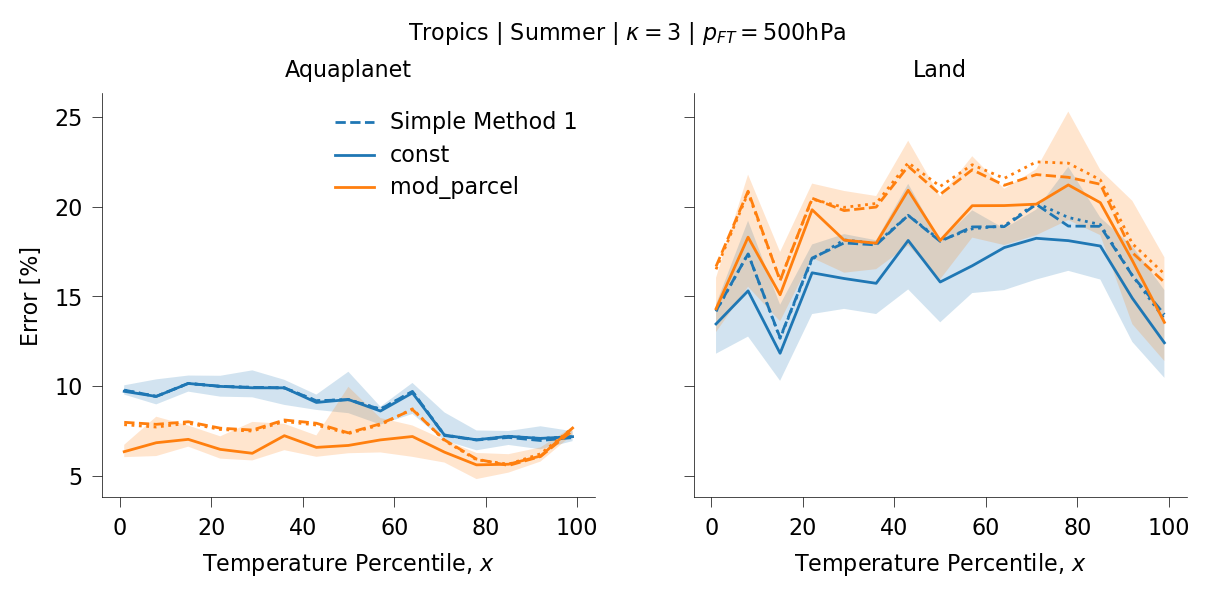

In [21]:
lat_weights = np.cos(np.deg2rad(ds.lat))
percentile_label = 'Temperature Percentile, $x$'

tau_lw_ind = 0
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    for j, key in enumerate(['const', 'mod_parcel']):
        for i in range(1, 3):
            var = np.abs(
                ds_quant[f'{key}{i}_error'].sum(dim='layer') / ds_quant[f'{key}{i}_integral'].sum(
                    dim='layer') * 100).isel(
                surf=k, tau_lw=tau_lw_ind)
            ax[k].plot(ds_quant.quant, np.average(var.quantile(0.5, dim='sample'), axis=1, weights=lat_weights),
                       linestyle=':' if i == 1 else None, color=f"C{j}", label=key if i == 2 else None)
            if i == 2:
                ax[k].fill_between(ds_quant.quant,
                                   np.average(var.quantile(0.25, dim='sample'), axis=1, weights=lat_weights),
                                   np.average(var.quantile(0.75, dim='sample'), axis=1, weights=lat_weights), alpha=0.2)
            else:
                var = np.abs(
                    ds_quant2[f'{key}1_error'].sum(dim='layer') / ds_quant2[f'{key}{i}_integral'].sum(
                        dim='layer') * 100).isel(surf=k, tau_lw=tau_lw_ind)
                ax[k].plot(ds_quant.quant, np.average(var.quantile(0.5, dim='sample'), axis=1, weights=lat_weights), linestyle='--',
                           color=f"C{j}", label='Simple Method 1' if j == 0 else None)

update_linewidth(fig)
ax[0].legend()
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $\kappa = {ds_quant.tau_lw.values[tau_lw_ind]}$ | $p_{'{FT}'} = {p_ft / 100:.0f}$hPa",
    y=1.02)
update_fontsize(fig)
ax[0].set_ylabel('Error [%]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
plt.show()

 ### Isca convection diagnostics
Below we see that the `mod_parcel` method above is worse than `const` for land because the shallow not deep convection scheme is being triggered, as indicated by `convflag`$\approx 1$. Whereas for aquaplanet, `convflag`$\approx 2$ indicating deep convection scheme is triggered.

This probably arises from the land being too dry to trigger deep convection in the SBM parameterization.

In [13]:
def lzb(k, P=ds.lev.to_numpy()):
    interp_func = scipy.interpolate.interp1d(np.arange(len(P)), P)
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k - 1))
    else:
        return interp_func(k - 1)

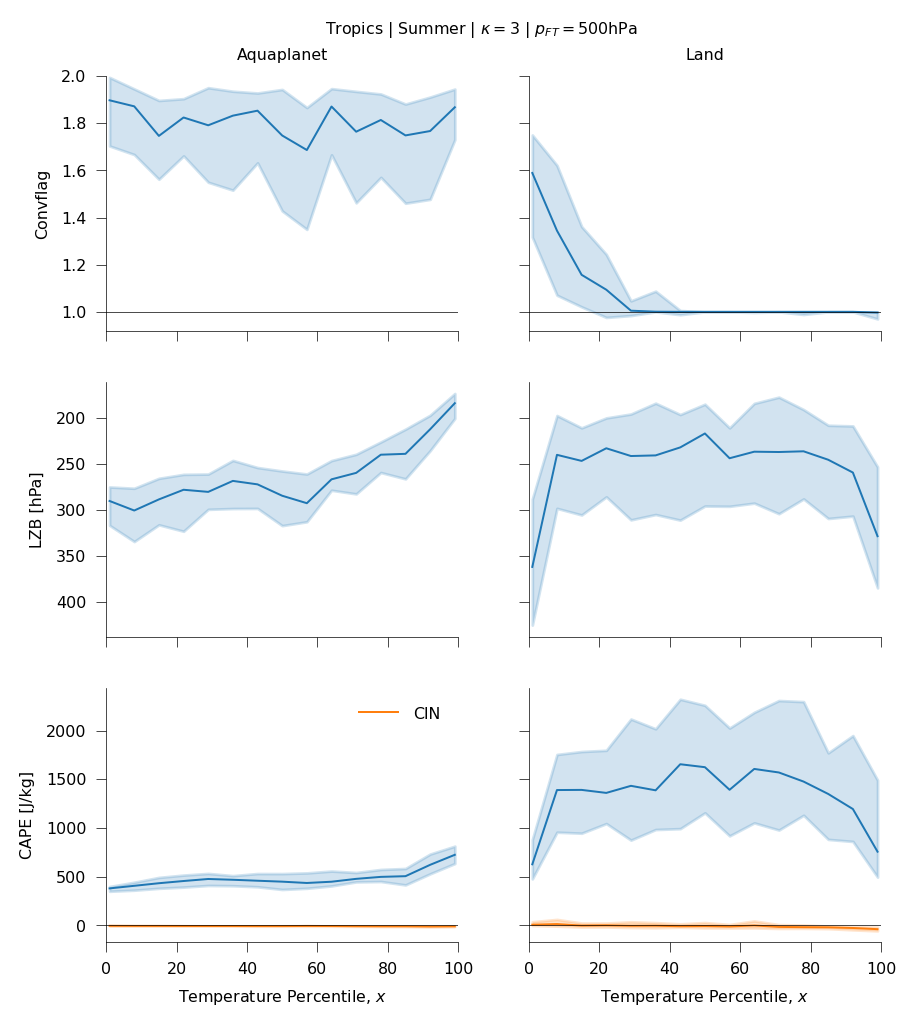

In [14]:
tau_lw_ind = 0
fig, ax = plt.subplots(3, 2, sharex=True, sharey='row')
fig_resize(fig, 5)
for k in range(ds.surf.size):
    ax[0, k].set_title(ds_quant.surf.values[k].capitalize())
    for i, var_name in enumerate(['convflag', 'klzbs', 'CAPE', 'cin']):
        if var_name == 'cin':
            i -= 1
        var = ds_quant[var_name].isel(surf=k, tau_lw=tau_lw_ind)
        if var_name == 'klzbs':
            var_new = lzb(var)
            var = unflatten_from_numpy(var_new.flatten(), var)
        ax[i, k].plot(ds_quant.quant, np.average(var.quantile(0.5, dim='sample'), axis=1, weights=lat_weights),
                      color=f"C1" if var_name == 'cin' else 'C0', label='CIN' if var_name == 'cin' else None)
        ax[i, k].fill_between(ds_quant.quant, np.average(var.quantile(0.25, dim='sample'), axis=1, weights=lat_weights),
                              np.average(var.quantile(0.75, dim='sample'), axis=1, weights=lat_weights), alpha=0.2,
                              color=f"C1" if var_name == 'cin' else 'C0')

update_linewidth(fig)
for i in range(2):
    ax[0, i].axhline(1, color='k', lw=ax_linewidth)
    ax[2, i].axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].set_xlim(0, 100)
ax[0, 0].set_ylim(ax[0, 0].get_ylim()[0], 2)
ax[1, 0].invert_yaxis()

ax[0, 0].set_ylabel('Convflag')
ax[1, 0].set_ylabel('LZB [hPa]')
ax[2, 0].set_ylabel('CAPE [J/kg]')
ax[2, 0].legend()
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $\kappa = {ds_quant.tau_lw.values[tau_lw_ind]}$ | $p_{'{FT}'} = {p_ft / 100:.0f}$hPa",
    y=0.93)
update_fontsize(fig)
ax[-1, 0].set_xlabel(percentile_label)
ax[-1, 1].set_xlabel(percentile_label)
plt.show()

§### Lapse rate fitting parameters
For above the LCL, the origin for the const applied to the parcel lapse rate for the `mod_parcel` case is shown by the black horizontal line.

For below the LCL, the black horizontal line indicates the dry adiabat.

The values are averaged over the tropics in the NH.

It is reassuring that for the aquaplanet, the `const_lapse` lapse rate above the LCL decreases for the hottest days, as expected by a moist adiabat.

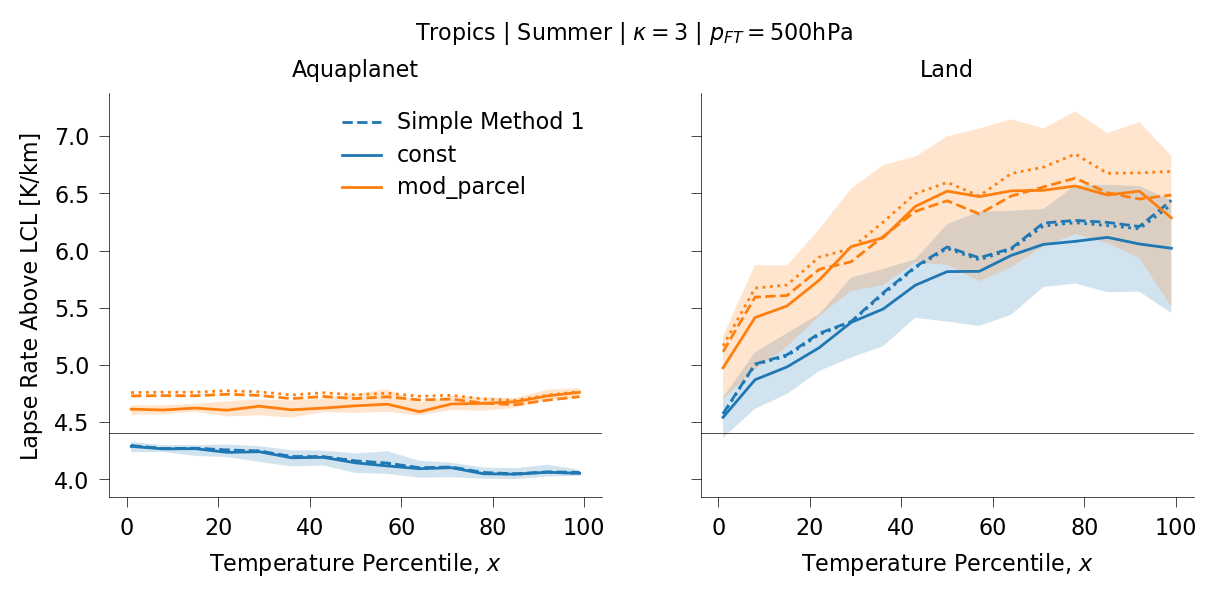

In [103]:
tau_lw_ind = 0
layer_ind = 1
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_quant.surf.values[k].capitalize())
    for j, key in enumerate(['const', 'mod_parcel']):
        for i in range(1, 3):
            var = ds_quant[f'{key}{i}_lapse'].isel(layer=layer_ind, surf=k, tau_lw=tau_lw_ind)
            if (layer_ind == 1) and (key == 'mod_parcel'):
                # Shift origin so can plot on same axis
                var = var + float(ds_quant[f'const2_lapse'].isel(layer=1).median())
            ax[k].plot(ds_quant.quant, np.average(var.quantile(0.5, dim='sample'), axis=1, weights=lat_weights),
                       linestyle=':' if i == 1 else None, color=f"C{j}", label=key if i == 2 else None)
            if i == 2:
                ax[k].fill_between(ds_quant.quant,
                                   np.average(var.quantile(0.25, dim='sample'), axis=1, weights=lat_weights),
                                   np.average(var.quantile(0.75, dim='sample'), axis=1, weights=lat_weights), alpha=0.2)
            else:
                var = ds_quant2[f'{key}{i}_lapse'].isel(layer=layer_ind, surf=k, tau_lw=tau_lw_ind)
                if (layer_ind == 1) and (key == 'mod_parcel'):
                    # Shift origin so can plot on same axis
                    var = var + float(ds_quant[f'const2_lapse'].isel(layer=1).median())
                ax[k].plot(ds_quant2.quant, np.average(var.quantile(0.5, dim='sample'), axis=1, weights=lat_weights),
                           linestyle='--', color=f"C{j}", label='Simple Method 1' if j == 0 else None)

update_linewidth(fig)
for i in range(len(ax)):
    ax[i].axhline(lapse_dry * 1000 if layer_ind == 0 else float(ds_quant[f'const2_lapse'].isel(layer=1).median()),
                  color='k', lw=ax_linewidth)

ax[0].legend()
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $\kappa = {ds_quant.tau_lw.values[tau_lw_ind]}$ | $p_{'{FT}'} = {p_ft / 100:.0f}$hPa",
    y=1.02)
update_fontsize(fig)
ax[0].set_ylabel(f'Lapse Rate {"Below" if layer_ind == 0 else "Above"} LCL [K/km]')
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
plt.show()

## Analysis as function of latitude
Next, for a single `TREFHT` quantiles, I plot the same quantities but as a function of latitude.

In [75]:
quant_use = 99
ds_lat = get_ds_quant(ds, quant_use, quant_range, quant_range, n_sample)
ds_lat['rh_REFHT'] = ds_lat.QREFHT / sphum_sat(ds_lat.TREFHT, ds_lat.PREFHT)
ds_lat2 = get_lapse_fitting_info2(copy.deepcopy(ds_lat))
ds_lat = get_lapse_fitting_info(ds_lat)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

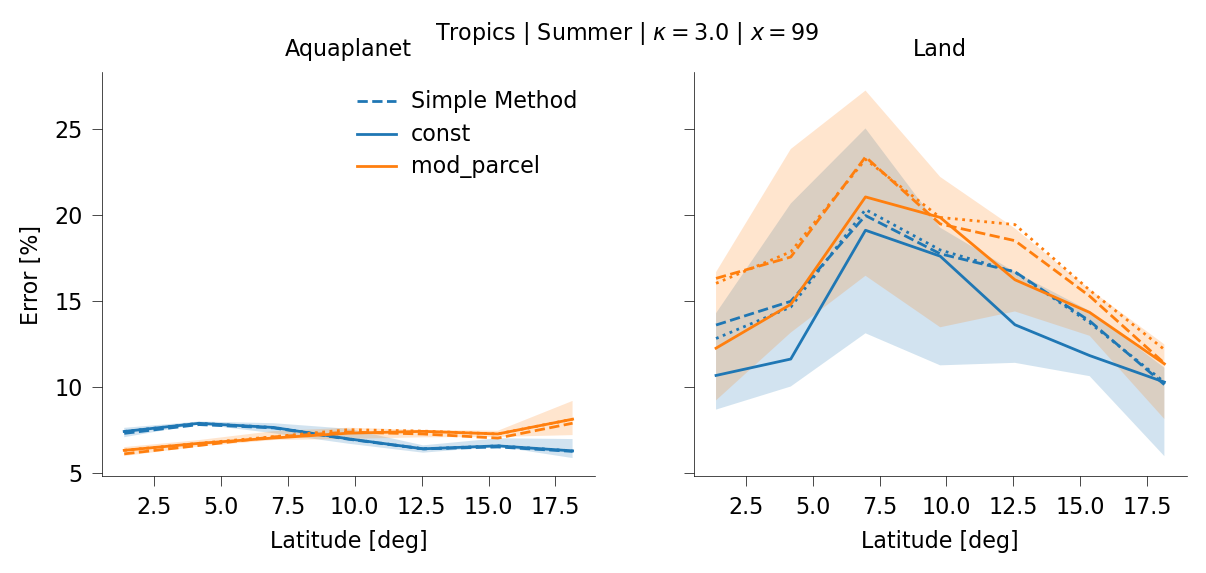

In [78]:
tau_lw_ind = 0
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
# var = [ds['lapse_below_env'] / ds.attrs['lapse_below_parcel'], ds['lapse_above_env'] / ds['lapse_above_parcel'],
#        ds['lapse_above_env'] / ds['lapse_above_parcel2']]
x_pos = [1 - 0.06, 1 + 0.06, 1.5 - 0.06, 1.5 + 0.06]
for k in range(ds.surf.size):
    ax[k].set_title(ds_lat.surf.values[k].capitalize())
    for j, key in enumerate(['const', 'mod_parcel']):
        for i in range(1, 3):
            var = np.abs(
                ds_lat[f'{key}{i}_error'].sum(dim='layer') / ds_lat[f'{key}{i}_integral'].sum(dim='layer') * 100).isel(
                surf=k, tau_lw=tau_lw_ind)
            ax[k].plot(ds_lat.lat, var.quantile(0.5, dim='sample').squeeze(), linestyle=':' if i == 1 else None,
                       color=f"C{j}",
                       label=key if i == 2 else None)
            if i == 2:
                ax[k].fill_between(ds_lat.lat, var.quantile(0.25, dim='sample').squeeze(),
                                   var.quantile(0.75, dim='sample').squeeze(), alpha=0.2)
            else:
                var = np.abs(
                    ds_lat2[f'{key}{i}_error'].sum(dim='layer') / ds_lat2[f'{key}{i}_integral'].sum(
                        dim='layer') * 100).isel(surf=k, tau_lw=tau_lw_ind)
                ax[k].plot(ds_lat.lat, var.quantile(0.5, dim='sample').squeeze(), linestyle='--',
                           color=f"C{j}", label='Simple Method' if j == 0 else None)

update_linewidth(fig)
ax[0].legend()
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $\kappa = {ds_lat.tau_lw.values[tau_lw_ind]:.1f}$ | $x={quant_use}$")
update_fontsize(fig)
ax[0].set_ylabel('Error [%]')
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
plt.show()

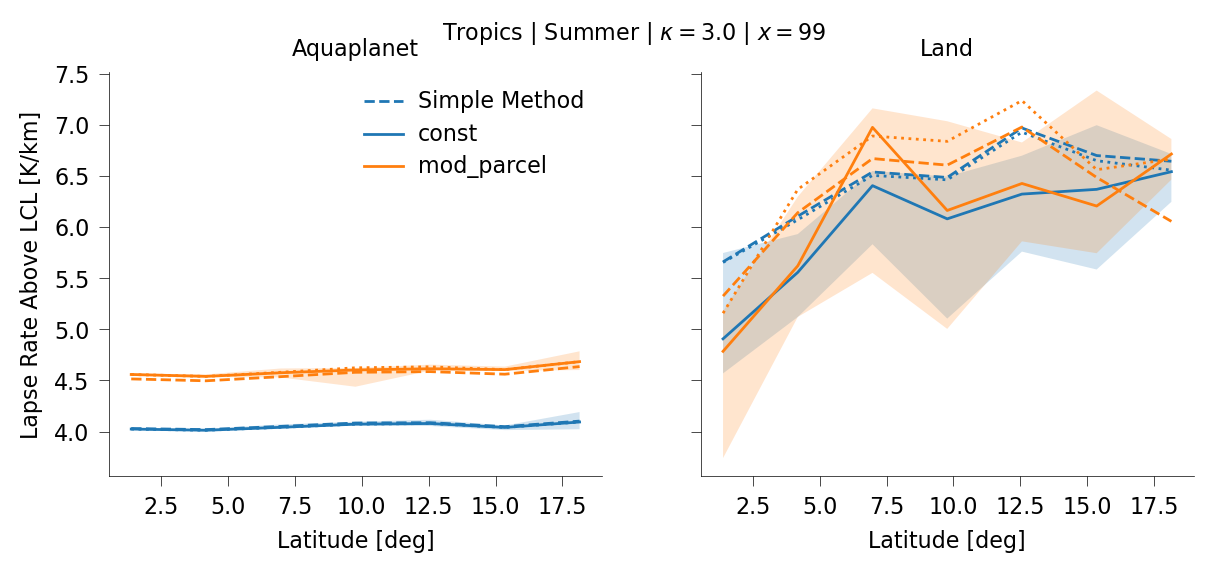

In [82]:
tau_lw_ind = 0
layer_ind = 1
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
for k in range(ds.surf.size):
    ax[k].set_title(ds_lat.surf.values[k].capitalize())
    for j, key in enumerate(['const', 'mod_parcel']):
        for i in range(1, 3):
            var = ds_lat[f'{key}{i}_lapse'].isel(layer=layer_ind, surf=k, tau_lw=tau_lw_ind)
            if (layer_ind == 1) and (key == 'mod_parcel'):
                var = var + float(ds_lat[f'const2_lapse'].isel(layer=1).median())
            ax[k].plot(ds_lat.lat, var.quantile(0.5, dim='sample').squeeze(), linestyle=':' if i == 1 else None,
                       color=f"C{j}",
                       label=key if i == 2 else None)
            if i == 2:
                ax[k].fill_between(ds_lat.lat, var.quantile(0.25, dim='sample').squeeze(),
                                   var.quantile(0.75, dim='sample').squeeze(), alpha=0.2)
            else:
                var = ds_lat2[f'{key}{i}_lapse'].isel(layer=layer_ind, surf=k, tau_lw=tau_lw_ind)
                if (layer_ind == 1) and (key == 'mod_parcel'):
                    var = var + float(ds_lat[f'const2_lapse'].isel(layer=1).median())
                ax[k].plot(ds_lat.lat, var.quantile(0.5, dim='sample').squeeze(), linestyle='--',
                           color=f"C{j}", label='Simple Method' if j == 0 else None)

update_linewidth(fig)
if layer_ind == 0:
    ax[0].axhline(lapse_dry * 1000, color='k', lw=ax_linewidth)
    ax[1].axhline(lapse_dry * 1000, color='k', lw=ax_linewidth)
ax[0].legend()
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | $\kappa = {ds_lat.tau_lw.values[tau_lw_ind]:.1f}$ | $x={quant_use}$")
update_fontsize(fig)
ax[0].set_ylabel(f'Lapse Rate {"Below" if layer_ind == 0 else "Above"} LCL [K/km]')
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
plt.show()

### Example Day
Below I take one of the days for the temperature percentile in `ds_lat`, and plot the fitting procedure.

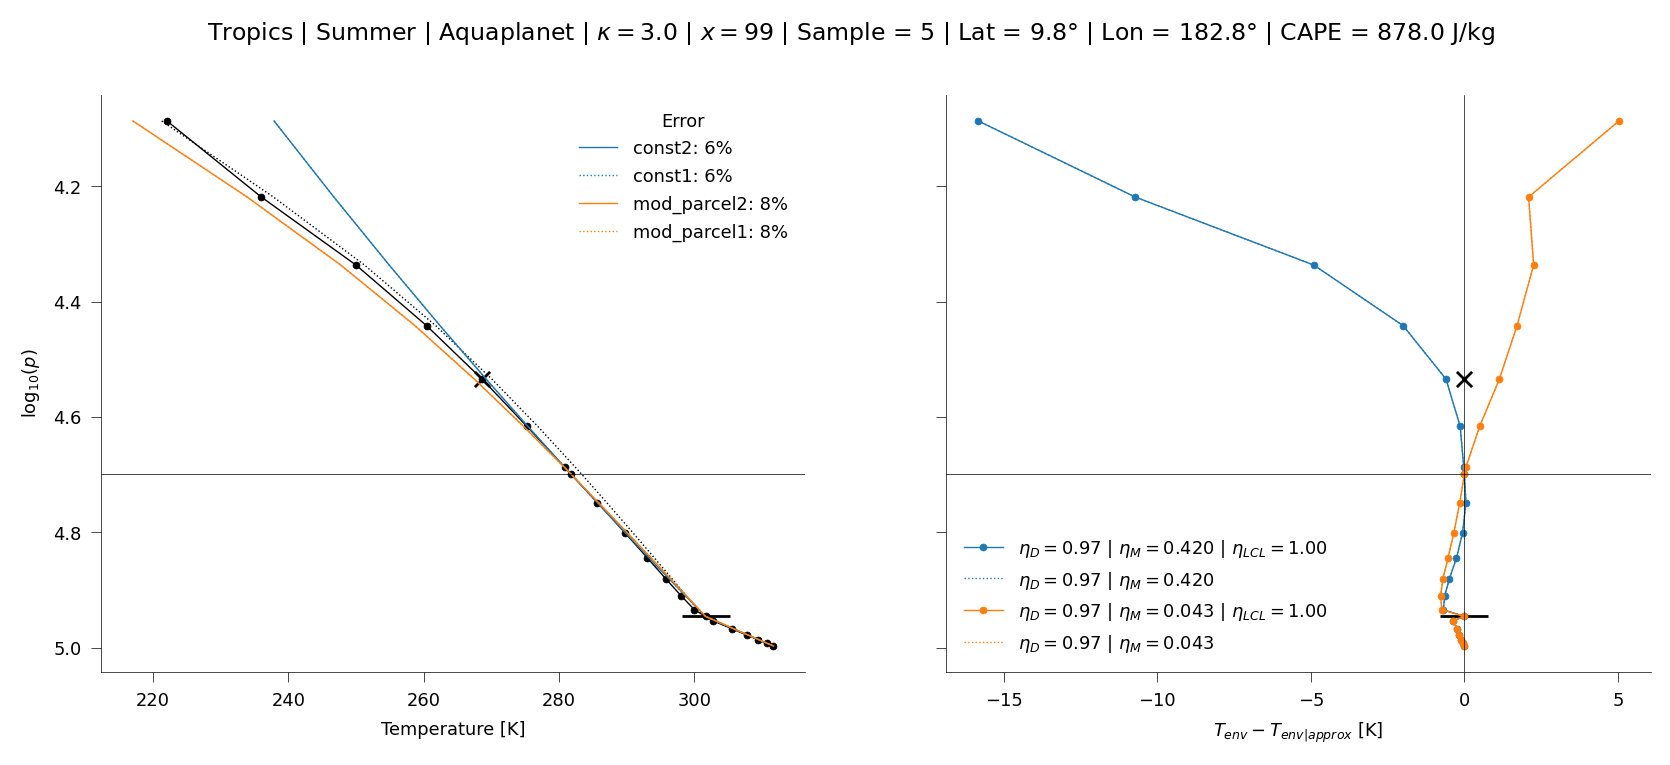

In [94]:
tau_lw_ind = 0
lat_ind = 3
sample_ind = 5
surf_ind = 0
ds_plot = ds_lat.isel(lat=lat_ind, sample=sample_ind, tau_lw=tau_lw_ind, surf=surf_ind)
ds_plot['lnb_ind'] = get_lnb_lev_ind(ds_plot.T, ds_plot.Z3, get_P(ds_plot))
ds_plot.attrs['p_ft'] = p_ft

p_thresh = float(get_P(ds_plot).isel(lev=ds_plot.lnb_ind) - 1)
# p_thresh = 300 * 100

show_phys_lcl = True
show_lcl_markers = True
fig, ax = plt.subplots(1, 2, sharey=True)
fig_resize(fig, 10)
p_use, temp_env_use = insert_to_array(get_P(ds_plot).to_numpy(), ds_plot.T.to_numpy(),
                                      [float(ds_plot.p_lcl), ds_plot.p_ft],
                                      [float(ds_plot.T_lcl_env), float(ds_plot.T_ft_env)])
use_lev = p_use >= p_thresh
ax[0].plot(temp_env_use[use_lev], np.log10(p_use)[use_lev], color='k', marker='o')

T_parcel_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                       float(ds_plot["p_lcl"]),
                                       lapse_dry, 0,
                                       method_layer2='mod_parcel')
ax[0].plot(T_parcel_use[use_lev], np.log10(p_use)[use_lev], color='k', linestyle=':')

for i, key in enumerate(['const2', 'mod_parcel2']):
    temp_approx_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                              float(ds_plot[f"{key}_p_lcl"]),
                                              float(ds_plot[f"{key}_lapse"].isel(layer=0)) / 1000,
                                              float(ds_plot[f"{key}_lapse"].isel(layer=1)) / 1000,
                                              method_layer2=key.replace('2', ''))
    label_use = f'{key}: {np.abs(np.sum(ds_plot[f"{key}_error"]) / np.sum(ds_plot[f"{key}_integral"]) * 100):.0f}%'
    ax[0].plot(temp_approx_use[use_lev], np.log10(p_use)[use_lev], color=f'C{i}',
               label=label_use)
    label_use = (f"$\eta_{'{D}'} = {ds_plot[f'{key}_lapse'].isel(layer=0) / lapse_dry / 1000:.2f}$ | "
                 f"$\eta_{'{M}'} = {ds_plot[f'{key}_lapse'].isel(layer=1) / lapse_dry / 1000:.3f}$ | "
                 f"$\eta_{'{LCL}'} = {ds_plot[f'{key}_p_lcl'] / ds_plot.p_lcl:.2f}$")
    ax[1].plot((temp_env_use - temp_approx_use)[use_lev], np.log10(p_use)[use_lev],
               color=f'C{i}', marker='o', label=label_use)

    if show_phys_lcl:
        key = key.replace('2', '1')
        temp_approx_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                                  float(ds_plot.p_lcl),
                                                  float(ds_plot[f"{key}_lapse"].isel(layer=0)) / 1000,
                                                  float(ds_plot[f"{key}_lapse"].isel(layer=1)) / 1000,
                                                  method_layer2=key.replace('1', ''))
        label_use = f'{key}: {np.abs(np.sum(ds_plot[f"{key}_error"]) / np.sum(ds_plot[f"{key}_integral"]) * 100):.0f}%'
        ax[0].plot(temp_approx_use[use_lev], np.log10(p_use)[use_lev], color=f'C{i}',
                   label=label_use, linestyle=':')
        label_use = (f"$\eta_{'{D}'} = {ds_plot[f'{key}_lapse'].isel(layer=0) / lapse_dry / 1000:.2f}$ | "
                     f"$\eta_{'{M}'} = {ds_plot[f'{key}_lapse'].isel(layer=1) / lapse_dry / 1000:.3f}$")
        ax[1].plot((temp_env_use - temp_approx_use)[use_lev], np.log10(p_use)[use_lev],
                   color=f'C{i}', label=label_use, linestyle=':')

if show_lcl_markers:
    ax[0].scatter(ds_plot.T_lcl_env, np.log10(ds_plot.p_lcl), marker='_', s=300, color='k', lw=1)
    ax[1].scatter(0, np.log10(ds_plot.p_lcl), marker='_', s=300, color='k', lw=1)
    for i, key in enumerate(['const2', 'mod_parcel2']):
        if np.abs(ds_plot[f'{key}_p_lcl'] - ds_plot[f'p_lcl']) > 1:
            ax[0].scatter(ds_plot[f'{key}_T_lcl_env'], np.log10(ds_plot[f'{key}_p_lcl']), marker='_', s=300,
                          color=f'C{i}', lw=1)
            ax[1].scatter(0, np.log10(ds_plot[f'{key}_p_lcl']), marker='_', s=300, color=f'C{i}', lw=1)

ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].invert_yaxis()
ax[0].legend(title='Error')
ax[1].legend()
ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('$T_{env} - T_{env | approx}$ [K]')
#
ax[0].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
p_integ_upper_ind = np.where(p_use < float(ds_plot.p_ft))[0][-ds_plot.n_lev_above_integral]
ax[0].scatter(temp_env_use[p_integ_upper_ind], np.log10(p_use[p_integ_upper_ind]), color='k', marker='x', s=30, lw=1)
ax[1].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
ax[1].scatter(0, np.log10(p_use[p_integ_upper_ind]), color='k', marker='x', s=30, lw=1)
#
# # update_linewidth(fig)
update_fontsize(fig, 4.5)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | {str(ds_plot.surf.values).capitalize()} | $\kappa = {float(ds_plot.tau_lw):.1f}$ | $x = {quant_use}$ | Sample = {sample_ind} | "
    f"Lat = {ds_plot.lat:.1f}$\degree$ | Lon = {ds_plot.lon:.1f}$\degree$ | CAPE = {float(ds_plot.CAPE):.1f} J/kg",
    fontsize=8.5)
plt.show()

### Simple Lapse Fitting
Below I repeat the above plot but with a simpler fitting procedure where the LCL is only determined by the surface relative humidity, and where the parcel profile is calculated slightly differently.

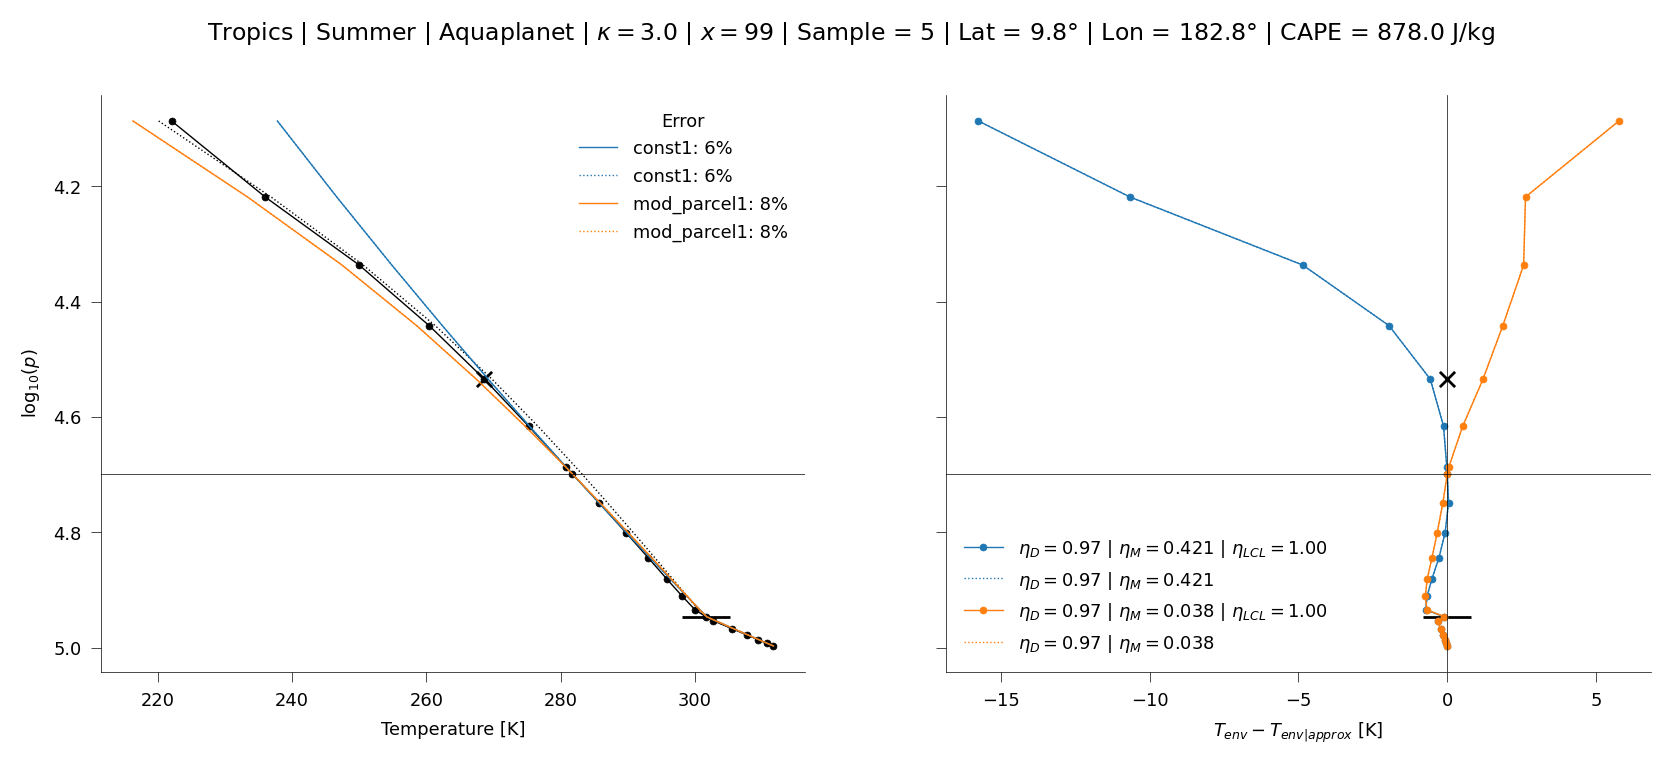

In [95]:
# ds_plot['rh_REFHT'] = ds_plot.QREFHT / sphum_sat(ds_plot.TREFHT, ds_plot.PREFHT)
ds_plot = ds_lat2.isel(lat=lat_ind, sample=sample_ind, tau_lw=tau_lw_ind, surf=surf_ind)
ds_plot['lnb_ind'] = get_lnb_lev_ind(ds_plot.T, ds_plot.Z3, get_P(ds_plot))
ds_plot['p_lcl'] = lcl_sigma_bolton_simple(ds_plot.rh_REFHT, 300) * ds_plot.PREFHT
ds_plot.attrs['p_ft'] = p_ft

fig, ax = plt.subplots(1, 2, sharey=True)
fig_resize(fig, 10)
p_use, temp_env_use = insert_to_array(get_P(ds_plot).to_numpy(), ds_plot.T.to_numpy(),
                                      [float(ds_plot.p_lcl), ds_plot.p_ft],
                                      [float(ds_plot.T_lcl_env), float(ds_plot.T_ft_env)])
use_lev = p_use >= p_thresh
ax[0].plot(temp_env_use[use_lev], np.log10(p_use)[use_lev], color='k', marker='o')

T_parcel_use = lapse_integral2.get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                                       float(ds_plot.rh_REFHT),
                                                       lapse_dry, 0,
                                                       method_layer2='mod_parcel')
ax[0].plot(T_parcel_use[use_lev], np.log10(p_use)[use_lev], color='k', linestyle=':')

for i, key in enumerate(['const1', 'mod_parcel1']):
    temp_approx_use = lapse_integral2.get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                                              float(ds_plot.rh_REFHT),
                                                              float(ds_plot[f"{key}_lapse"].isel(layer=0)) / 1000,
                                                              float(ds_plot[f"{key}_lapse"].isel(layer=1)) / 1000,
                                                              method_layer2=key.replace('1', ''))
    label_use = f'{key}: {np.abs(np.sum(ds_plot[f"{key}_error"]) / np.sum(ds_plot[f"{key}_integral"]) * 100):.0f}%'
    ax[0].plot(temp_approx_use[use_lev], np.log10(p_use)[use_lev], color=f'C{i}',
               label=label_use)
    label_use = (f"$\eta_{'{D}'} = {ds_plot[f'{key}_lapse'].isel(layer=0) / lapse_dry / 1000:.2f}$ | "
                 f"$\eta_{'{M}'} = {ds_plot[f'{key}_lapse'].isel(layer=1) / lapse_dry / 1000:.3f}$ | "
                 f"$\eta_{'{LCL}'} = {ds_plot[f'p_lcl'] / ds_plot.p_lcl:.2f}$")
    ax[1].plot((temp_env_use - temp_approx_use)[use_lev], np.log10(p_use)[use_lev],
               color=f'C{i}', marker='o', label=label_use)

    if show_phys_lcl:
        key = key.replace('2', '1')
        temp_approx_use = lapse_integral2.get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                                                  float(ds_plot.rh_REFHT),
                                                                  float(ds_plot[f"{key}_lapse"].isel(layer=0)) / 1000,
                                                                  float(ds_plot[f"{key}_lapse"].isel(layer=1)) / 1000,
                                                                  method_layer2=key.replace('1', ''))
        label_use = f'{key}: {np.abs(np.sum(ds_plot[f"{key}_error"]) / np.sum(ds_plot[f"{key}_integral"]) * 100):.0f}%'
        ax[0].plot(temp_approx_use[use_lev], np.log10(p_use)[use_lev], color=f'C{i}',
                   label=label_use, linestyle=':')
        label_use = (f"$\eta_{'{D}'} = {ds_plot[f'{key}_lapse'].isel(layer=0) / lapse_dry / 1000:.2f}$ | "
                     f"$\eta_{'{M}'} = {ds_plot[f'{key}_lapse'].isel(layer=1) / lapse_dry / 1000:.3f}$")
        ax[1].plot((temp_env_use - temp_approx_use)[use_lev], np.log10(p_use)[use_lev],
                   color=f'C{i}', label=label_use, linestyle=':')
#
if show_lcl_markers:
    ax[0].scatter(ds_plot.T_lcl_env, np.log10(ds_plot.p_lcl), marker='_', s=300, color='k', lw=1)
    ax[1].scatter(0, np.log10(ds_plot.p_lcl), marker='_', s=300, color='k', lw=1)
    for i, key in enumerate(['const2', 'mod_parcel2']):
        if np.abs(ds_plot[f'p_lcl'] - ds_plot[f'p_lcl']) > 1:
            ax[0].scatter(ds_plot[f'{key}_T_lcl_env'], np.log10(ds_plot[f'{key}_p_lcl']), marker='_', s=300,
                          color=f'C{i}', lw=1)
            ax[1].scatter(0, np.log10(ds_plot[f'{key}_p_lcl']), marker='_', s=300, color=f'C{i}', lw=1)
#
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].invert_yaxis()
ax[0].legend(title='Error')
ax[1].legend()
ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('$T_{env} - T_{env | approx}$ [K]')
#
ax[0].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
p_integ_upper_ind = np.where(p_use < float(ds_plot.p_ft))[0][-ds_plot.n_lev_above_integral]
ax[0].scatter(temp_env_use[p_integ_upper_ind], np.log10(p_use[p_integ_upper_ind]), color='k', marker='x', s=30, lw=1)
ax[1].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
ax[1].scatter(0, np.log10(p_use[p_integ_upper_ind]), color='k', marker='x', s=30, lw=1)
#
# # update_linewidth(fig)
update_fontsize(fig, 4.5)
fig.suptitle(
    f"{region.capitalize()} | {season.capitalize()} | {str(ds_plot.surf.values).capitalize()} | $\kappa = {float(ds_plot.tau_lw):.1f}$ | $x = {quant_use}$ | Sample = {sample_ind} | "
    f"Lat = {ds_plot.lat:.1f}$\degree$ | Lon = {ds_plot.lon:.1f}$\degree$ | CAPE = {float(ds_plot.CAPE):.1f} J/kg",
    fontsize=8.5)
plt.show()